<a href="https://colab.research.google.com/github/vivek-163/NeuralStyleTransfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🎨 Neural Style Transfer
# Project Overview
Neural Style Transfer (NST) is a deep learning technique that applies the artistic style of one image to another while preserving its content. In this project, we use VGG19, a pre-trained deep neural network, to extract features from images and blend their style and content.

## Installing all dependencies


In [ ]:
!pip install tensorflow numpy matplotlib pillow -q

##📷 Input Images
NST requires two images:

1. Content Image → The image whose structure we want to retain.

2. Style Image → The artistic painting that provides colors and textures.

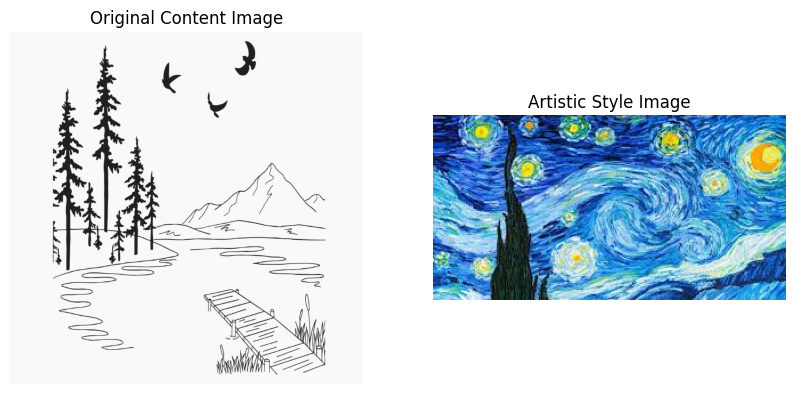

In [ ]:
import matplotlib.pyplot as plt
import PIL.Image

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(PIL.Image.open("content.jpg"))
plt.title("Original Content Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(PIL.Image.open("style.jpeg"))
plt.title("Artistic Style Image")
plt.axis("off")

plt.show()

###Load & Process Images
Since deep learning models require numerical inputs, we need to:

1. Resize the images to 400x400 pixels
(to reduce computation time).

2. Convert them into numerical arrays.

3. Preprocess them for VGG19 input format.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from tensorflow.keras.applications import vgg19

# Function to load and process the image
def load_and_process_image(image_path):
    img = PIL.Image.open(image_path)
    img = img.resize((400, 400))  # Resize for faster processing
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = vgg19.preprocess_input(img)  # Preprocess for VGG19
    return img

# Load content and style images
content_path = "content.jpg"
style_path = "style.jpeg"

content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)

print("Images loaded successfully!")


Images loaded successfully!


## Load Pretrained VGG19 Model
We use VGG19, a deep learning model trained on ImageNet, to extract features from the images.

1. Content Features → Capture the structure of the content image.
2. Style Features → Capture artistic brush strokes and textures from the style image.

In [ ]:
# Load the pre-trained VGG19 model
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights="imagenet")  # Load VGG19 without the top layer
    vgg.trainable = False  # Freeze the model (we don’t train it)

    # Define the content layer and style layers
    content_layer = "block5_conv2"
    style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]

    # Extract outputs from these layers
    model_outputs = [vgg.get_layer(name).output for name in style_layers + [content_layer]]
    return tf.keras.Model(inputs=vgg.input, outputs=model_outputs)

# Load the model
model = get_model()
print("VGG19 Model loaded successfully!")


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
VGG19 Model loaded successfully!


### Compute Style Loss Using Gram Matrix
NST uses a Gram Matrix to compare the style features of images.

It captures spatial patterns of colors and textures in the image.

🔹 Code for Computing Gram Matrix:

In [ ]:
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])  # Number of channels
    vectorized = tf.reshape(tensor, [-1, channels])  # Flatten the feature map
    return tf.matmul(tf.transpose(vectorized), vectorized) / tf.cast(tf.size(tensor), tf.float32)


##Define Loss Function
We define a loss function that balances:

✔ Content Loss → Ensures the original structure is retained.

✔ Style Loss → Ensures artistic features are applied.

🔹 Compute Loss Function:

In [ ]:
def compute_loss(model, content_image, style_image, generated_image):
    outputs = model(tf.concat([style_image, content_image, generated_image], axis=0))

    style_outputs = outputs[:-1]  # Extract all style layers
    content_output = outputs[-1]  # Last one is content layer

    # Get the style features separately
    style_targets = model(style_image)[:-1]

    # Compute Content Loss
    content_loss = tf.reduce_mean((content_output - model(content_image)[-1]) ** 2)

    style_loss = 0
    for output, target in zip(style_outputs, style_targets):
        gram_output = gram_matrix(output)
        gram_target = gram_matrix(target)

        if gram_output.shape != gram_target.shape:
            print(f"Warning: Mismatched shapes {gram_output.shape} vs {gram_target.shape}")

        style_loss += tf.reduce_mean((gram_output - gram_target) ** 2)

    # Adjusted weights: More emphasis on content
    total_loss = content_loss * 1e2 + style_loss * 1e-1
    return total_loss



## Training & Optimization

1. We use Adam Optimizer to update the generated image step by step.

2. Training works by minimizing the loss function to refine the stylized output.


🔹 Optimization Setup

In [ ]:
generated_image = tf.Variable(content_image, dtype=tf.float32)
optimizer = tf.optimizers.Adam(learning_rate=5.0)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = compute_loss(model, content_image, style_image, generated_image)
    gradients = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    return loss


print("Optimization setup complete!")



Optimization setup complete!


## Train the Model

We run 600 iterations to optimize the stylized image.

The loss decreases over time, indicating improvement.


🔹 Training Loop:

In [ ]:
loss_history = []  #List to store loss values

epochs = 1000  #You can change this based on your training steps

for i in range(epochs):
    loss_value = train_step()
    loss_history.append(loss_value.numpy())  #Store loss

    if i % 50 == 0:
        print(f"Step {i}, Loss: {loss_value.numpy()}")

print("Training complete! ")




Step 0, Loss: 276796.34375
Step 50, Loss: 213367.4375
Step 100, Loss: 208109.71875
Step 150, Loss: 206149.15625
Step 200, Loss: 205191.34375
Step 250, Loss: 204522.65625
Step 300, Loss: 204045.40625
Step 350, Loss: 203777.78125
Step 400, Loss: 203365.453125
Step 450, Loss: 203225.046875
Step 500, Loss: 202954.03125
Step 550, Loss: 202799.25
Step 600, Loss: 202662.75
Step 650, Loss: 202594.90625
Step 700, Loss: 202492.5
Step 750, Loss: 202328.53125
Step 800, Loss: 202282.390625
Step 850, Loss: 202167.359375
Step 900, Loss: 202083.390625
Step 950, Loss: 202076.375
Training complete! 


 ## Plot Loss Curve
We visualize how loss decreases over training.

🔹 Loss Curve Plot:

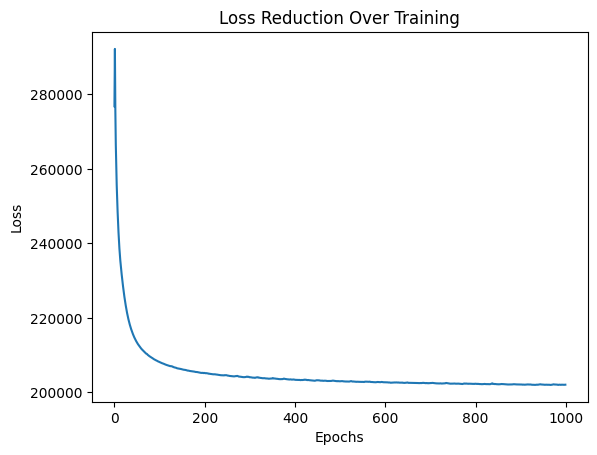

In [ ]:
import matplotlib.pyplot as plt

# Assume 'loss_history' stores loss values over epochs
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Reduction Over Training")
plt.show()


##Generate & Save Final Stylized Image

Once training is complete, we convert the final image back to a displayable format and save it.

🔹 Convert & Save Image:

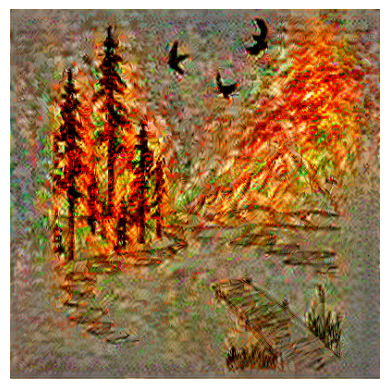

Final Van Gogh-stylized image saved as 'final_vangogh_stylized.jpg'


In [ ]:
import PIL.Image
import numpy as np

def deprocess_image(image):
    image = image.numpy().squeeze()
    image = np.clip(image, 0, 255).astype("uint8")
    return PIL.Image.fromarray(image)

result_image = deprocess_image(generated_image)
result_image.save("final_vangogh_stylized.jpg")

# Show the image
plt.imshow(result_image)
plt.axis("off")
plt.show()

print("Final Van Gogh-stylized image saved as 'final_vangogh_stylized.jpg'")



## Download Final Image

To save and use the image, download it.

In [ ]:
from google.colab import files
files.download("final_vangogh_stylized.jpg")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Sharpening the resulted image

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Correct method for Colab

# Load the generated image
image = cv2.imread("final_vangogh_stylized.jpg")

# Apply sharpening kernel
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened = cv2.filter2D(image, -1, kernel)

# Save the sharpened image
cv2.imwrite("sharpened_output.jpg", sharpened)

# Display the sharpened image in Colab
cv2_imshow(sharpened)

print("Sharpened image saved as 'sharpened_output.jpg' 🎉")